This model has been developed to address the problem statement below.


**Problem Statement:**
"Develop a sales forecasting model to predict daily sales volumes for each item type across different supermarket branches, considering temporal factors (time of day, day of week), location features (province, supermarket), and customer behavior patterns (voucher usage). 
This will help optimize inventory management and improve supply chain efficiency."


In [1]:
import pandas as pd

# path to our dataset
file_path = '/kaggle/input/dataset-for-problem1/dataset_for_problem1.csv'
df = pd.read_csv(file_path)

# Display the first few rows to verify the data
print(df.head())

         code  amount  units  province  week  customerId  day  voucher  \
0  7680850106    0.80      1         2     1      125434    1        0   
1  7680850106    1.60      2         2     1      503106    4        0   
2  7680850106    1.19      1         2     4       18851   23        0   
3  7680850106    1.19      1         2     6       26918   37        0   
4  7680850106    0.79      1         2     7        8748   45        0   

  standard_time time_of_day  ...  total_sales    type    brand   size  \
0         11:00     morning  ...         0.80  type 2  barilla  16 OZ   
1         15:18   afternoon  ...         3.20  type 2  barilla  16 OZ   
2         15:17   afternoon  ...         1.19  type 2  barilla  16 OZ   
3         13:12   afternoon  ...         1.19  type 2  barilla  16 OZ   
4         13:17   afternoon  ...         0.79  type 2  barilla  16 OZ   

  size_in_grams  type_encoded  brand_category size_in_grams_scaled  \
0       453.592             1         barilla 

In [2]:
# Check for null values
null_summary = df.isnull().sum()
print("Null values in the dataset:")
print(null_summary[null_summary > 0])


# Check for duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Null values in the dataset:
Series([], dtype: int64)
Number of duplicate rows: 0


In [3]:
# Ensure columns are of the correct data types
df['week'] = df['week'].astype(int)
df['day'] = df['day'].astype(int)
df['units'] = df['units'].astype(float)  # Ensure units are numeric

In [4]:
# Compute correlation for week and day with units
correlation_week = df['week'].corr(df['units'])
correlation_day = df['day'].corr(df['units'])

print(f"Correlation between week and units: {correlation_week}")
print(f"Correlation between day and units: {correlation_day}")

Correlation between week and units: 0.0121737448672232
Correlation between day and units: 0.012490354771691064


In [5]:
from scipy.stats import f_oneway

# ANOVA test for week and units
anova_week = f_oneway(*[df[df['week'] == w]['units'] for w in df['week'].unique()])
anova_day = f_oneway(*[df[df['day'] == d]['units'] for d in df['day'].unique()])

print(f"ANOVA test for week and units: p-value = {anova_week.pvalue}")
print(f"ANOVA test for day and units: p-value = {anova_day.pvalue}")

ANOVA test for week and units: p-value = 0.0
ANOVA test for day and units: p-value = 0.0


In [6]:
import matplotlib.pyplot as plt  # Import the pyplot module

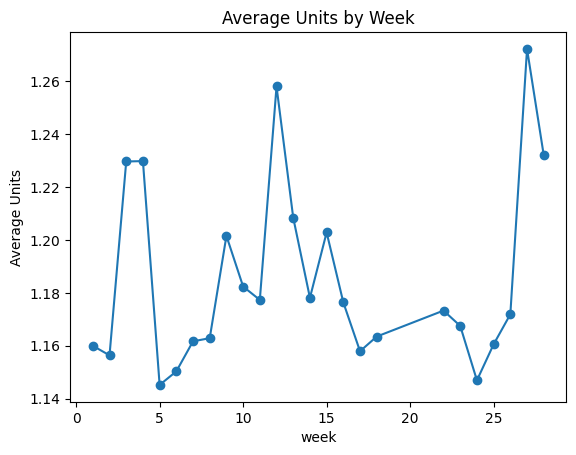

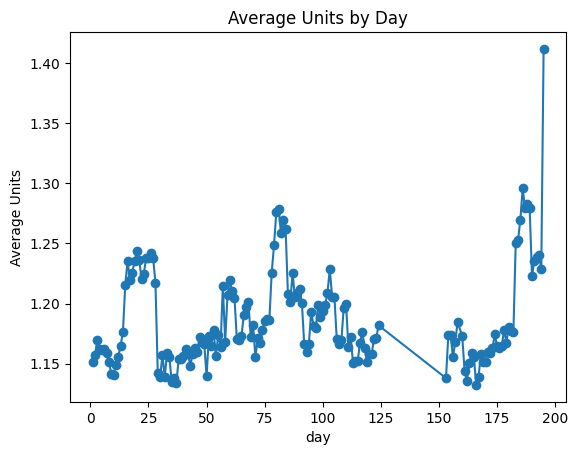

In [7]:
# Line plot for average units by week
df.groupby('week')['units'].mean().plot(kind='line', marker='o', title='Average Units by Week')
plt.ylabel('Average Units')
plt.show()

# Line plot for average units by day
df.groupby('day')['units'].mean().plot(kind='line', marker='o', title='Average Units by Day')
plt.ylabel('Average Units')
plt.show()

In [8]:
# Print unique values in 'week' column
unique_weeks = df['week'].unique()
print(f"Unique values in 'week': {unique_weeks}")

# Print unique values in 'day' column
unique_days = df['day'].unique()
print(f"Unique values in 'day': {unique_days}")

Unique values in 'week': [ 1  4  6  7  8  9 11 12 15 16 24 27 28  2  3  5 10 13 26 25 14 23 22 17
 18]
Unique values in 'day': [  1   4  23  37  45  46  52  54  56  59  71  72  83  99 112 165 184 189
 190  11  16  34  43  50  66 101   7   6  15  17  19  22  27  26  44  57
  58  63  70  73  77  88  89 111 176 180   2  12  42  48  75  82 107 175
  25  35  41  39  61  68  97  98 109 156 158 161 181 185   9  10  31  49
  60  69  94 162 164 173 177 183  92  13  67  78  87 187   8  28  33  62
  74  80 103 167 170 179   3  30  18  20  29  38  51  86  95 100 105 106
 155 157 171  36  79 178  40  64  76 163  55  85 160 166  32  93  96 168
 182  47 110 102 108  91  90  14 104  24  81 186  21  53   5  84 174 188
  65 172 169 154 116 194 117 123 120 191 121 114 118 122 192 113 193 119
 115 153 195 124]


**model development**

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [10]:
#number of rows in the dataset
print(len(df))

1033368


In [11]:
# Sample 75% of the data
df = df.sample(frac=0.75, random_state=42)

In [12]:
print(len(df))

775026


In [13]:

# Feature Engineering
# Aggregate data to predict demand for brand × type during different times of the day
aggregated_data = df.groupby(['brand', 'type', 'time_of_day', 'week', 'day', 'voucher', 'province'])['units'].sum().reset_index()

In [14]:
Q1 = aggregated_data['units'].quantile(0.25)
Q3 = aggregated_data['units'].quantile(0.75)
IQR = Q3 - Q1

outlier_condition = (aggregated_data['units'] < (Q1 - 1.5 * IQR)) | (aggregated_data['units'] > (Q3 + 1.5 * IQR))
outliers_iqr = aggregated_data[outlier_condition]
print(outliers_iqr)

             brand    type time_of_day  week  day  voucher  province  units
795    aunt jemima  type 1   afternoon    16  112        0         1   38.0
808    aunt jemima  type 1   afternoon    22  154        0         1   42.0
814    aunt jemima  type 1   afternoon    23  157        0         1   41.0
816    aunt jemima  type 1   afternoon    23  158        0         1   72.0
817    aunt jemima  type 1   afternoon    23  158        0         2   43.0
...            ...     ...         ...   ...  ...      ...       ...    ...
42540  san giorgio  type 2     morning    12   78        0         2   42.0
42557  san giorgio  type 2     morning    12   84        0         2   40.0
42655  san giorgio  type 2     morning    23  158        0         2   43.0
42692  san giorgio  type 2     morning    25  175        0         2   47.0
42710  san giorgio  type 2     morning    26  182        0         2   46.0

[6259 rows x 8 columns]


In [15]:
# Apply logarithmic transformation
aggregated_data['log_units'] = np.log(aggregated_data['units'] + 1)

# Verify the transformation
print(aggregated_data[['units', 'log_units']].describe())

              units     log_units
count  45044.000000  45044.000000
mean      20.465567      2.071072
std       49.158285      1.252847
min        1.000000      0.693147
25%        2.000000      1.098612
50%        5.000000      1.791759
75%       16.000000      2.833213
max     1110.000000      7.013016


In [16]:
# Encode categorical features using LabelEncoder
label_encoders = {}
for column in ['brand', 'type', 'province', 'voucher', 'time_of_day']:
    le = LabelEncoder()
    aggregated_data[column] = le.fit_transform(aggregated_data[column])
    label_encoders[column] = le  # Save encoder for possible inverse transformation

In [17]:
# Prepare final features and target
X = aggregated_data[['week', 'day', 'brand', 'type', 'province', 'voucher', 'time_of_day']]
y = aggregated_data['log_units']

In [18]:
# Print the features used to train the model
print("Features used to train the model:")
print(X.columns.tolist())


Features used to train the model:
['week', 'day', 'brand', 'type', 'province', 'voucher', 'time_of_day']


In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=200, random_state=42, max_depth=10, min_samples_split=5)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_split=5, n_estimators=200,
                      random_state=42)

In [21]:
# Predict and Evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


In [22]:
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

RMSE: 0.49
R² Score: 0.85


In [23]:
# Identify High-Demand Combinations
test_data = X_test.copy()
test_data['predicted_units'] = y_pred

In [24]:
# Top 10 high-demand combinations
high_demand = test_data.sort_values(by='predicted_units', ascending=False).head(10)
high_demand_combination_names = high_demand.columns
print("Top 10 High-Demand Brand × Type Combinations:")
print(high_demand[high_demand_combination_names])

Top 10 High-Demand Brand × Type Combinations:
       week  day  brand  type  province  voucher  time_of_day  predicted_units
40185    27  188     88     2         1        0            1         6.031816
40181    27  187     88     2         1        0            1         6.031816
40168    27  184     88     2         0        0            1         6.031816
40184    27  188     88     2         0        0            1         6.031816
40188    27  189     88     2         0        0            1         6.031816
39607    27  185     88     2         1        0            0         6.031816
40165    27  183     88     2         1        0            1         6.000765
39598    27  183     88     2         0        0            0         6.000765
39626    28  190     88     2         0        0            0         5.881608
39630    28  191     88     2         0        0            0         5.877924


In [25]:
# Insights
total_demand = high_demand['predicted_units'].sum()
print(f"\nTotal Predicted Demand for Top 10 Combinations: {total_demand:.2f}")


Total Predicted Demand for Top 10 Combinations: 59.95


In [26]:
# Recommend inventory adjustments based on predictions
average_demand = high_demand['predicted_units'].mean()
print(f"Recommended Average Inventory Level for Top 10 Combinations: {average_demand:.2f}")


Recommended Average Inventory Level for Top 10 Combinations: 6.00


In [27]:
# Further insights: Identify combinations with highest demand variance
demand_variance = high_demand.groupby(['brand', 'type'])['predicted_units'].var().reset_index()
demand_variance = demand_variance.sort_values(by='predicted_units', ascending=False).head(10)
print("\nTop 10 Brand × Type Combinations with Highest Demand Variance:")
print(demand_variance)


Top 10 Brand × Type Combinations with Highest Demand Variance:
   brand  type  predicted_units
0     88     2         0.003863


Top Feature Importances:
       Feature  Importance
0        brand    0.557132
1         type    0.218790
2      voucher    0.110925
3  time_of_day    0.055346
4     province    0.028515
5          day    0.023323
6         week    0.005968


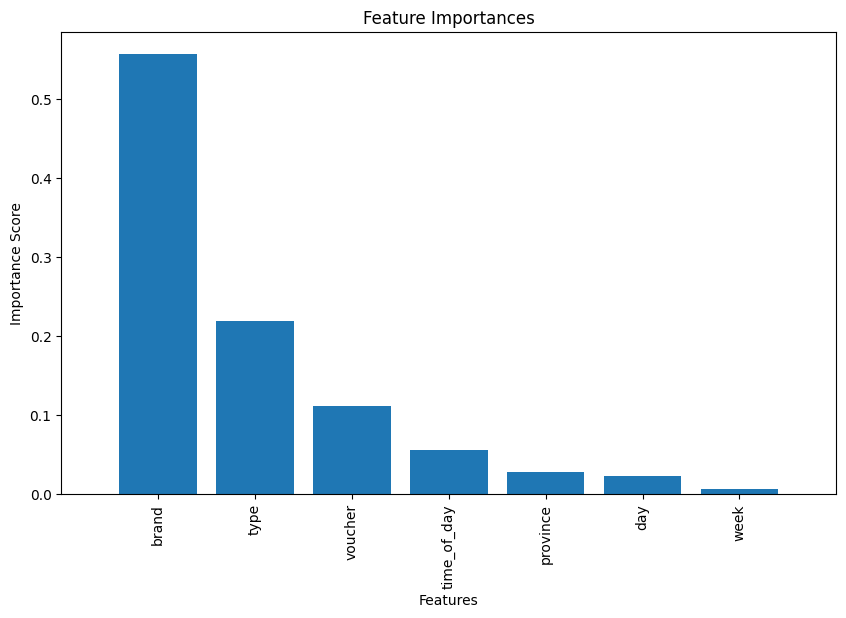

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Create a DataFrame for better readability
importance_df = pd.DataFrame({
    'Feature': feature_names[indices],
    'Importance': importances[indices]
})

# Print the top features
print("Top Feature Importances:")
print(importance_df.head(10))  # Display the top 10 features

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.ylabel('Importance Score')
plt.xlabel('Features')
plt.show()


**Hyperparameter Tuning**

In [29]:
# Sample 75% of the data
df = df.sample(frac=0.75, random_state=42)

In [30]:

# Feature Engineering
# Aggregate data to predict demand for brand × type during different times of the day
aggregated_data = df.groupby(['brand', 'type', 'time_of_day', 'week', 'day', 'voucher', 'province'])['units'].sum().reset_index()

In [31]:
Q1 = aggregated_data['units'].quantile(0.25)
Q3 = aggregated_data['units'].quantile(0.75)
IQR = Q3 - Q1

outlier_condition = (aggregated_data['units'] < (Q1 - 1.5 * IQR)) | (aggregated_data['units'] > (Q3 + 1.5 * IQR))
outliers_iqr = aggregated_data[outlier_condition]
print(outliers_iqr)

             brand    type time_of_day  week  day  voucher  province  units
697    aunt jemima  type 1   afternoon    23  157        0         1   31.0
699    aunt jemima  type 1   afternoon    23  158        0         1   52.0
700    aunt jemima  type 1   afternoon    23  158        0         2   34.0
711    aunt jemima  type 1   afternoon    24  165        0         1   31.0
715    aunt jemima  type 1   afternoon    24  167        0         1   32.0
...            ...     ...         ...   ...  ...      ...       ...    ...
39781  san giorgio  type 2     morning    12   78        0         2   33.0
39886  san giorgio  type 2     morning    23  158        0         2   35.0
39907  san giorgio  type 2     morning    25  170        0         2   31.0
39921  san giorgio  type 2     morning    25  175        0         2   42.0
39938  san giorgio  type 2     morning    26  182        0         2   35.0

[6005 rows x 8 columns]


In [32]:
# Apply logarithmic transformation
aggregated_data['log_units'] = np.log(aggregated_data['units'] + 1)

# Verify the transformation
print(aggregated_data[['units', 'log_units']].describe())

              units     log_units
count  41992.000000  41992.000000
mean      16.467160      1.956463
std       38.024459      1.185722
min        1.000000      0.693147
25%        2.000000      1.098612
50%        4.000000      1.609438
75%       13.000000      2.639057
max      818.000000      6.708084


In [33]:
# Encode categorical features using LabelEncoder
label_encoders = {}
for column in ['brand', 'type', 'province', 'voucher', 'time_of_day']:
    le = LabelEncoder()
    aggregated_data[column] = le.fit_transform(aggregated_data[column])
    label_encoders[column] = le  # Save encoder for possible inverse transformation

In [34]:
# Prepare final features and target
X = aggregated_data[['week', 'day', 'brand', 'type', 'province', 'voucher', 'time_of_day']]
y = aggregated_data['log_units']

In [35]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# Define the Random Forest Regressor
model = RandomForestRegressor(random_state=42)

In [37]:
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [38]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_distributions=param_dist, 
                                   n_iter=100, cv=3, 
                                   scoring='neg_mean_squared_error', 
                                   random_state=42, 
                                   n_jobs=-1)

In [39]:
# Fit the model
random_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50],
                                        'max_features': [1.0, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='neg_mean_squared_error')

In [40]:
# Get the best parameters
best_params = random_search.best_params_
print("Best Hyperparameters:")
print(best_params)

Best Hyperparameters:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 1.0, 'max_depth': 40, 'bootstrap': True}


In [41]:
# Predict using the best model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

In [42]:
# Assuming y is your target variable
print(y.describe())

count    41992.000000
mean         1.956463
std          1.185722
min          0.693147
25%          1.098612
50%          1.609438
75%          2.639057
max          6.708084
Name: log_units, dtype: float64


In [43]:
# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

RMSE: 0.4349179039512232
Mean Absolute Error (MAE): 0.32997344723092004
R² Score: 0.8651455999207729


In [44]:
# Identify High-Demand Combinations
test_data = X_test.copy()
test_data['predicted_units'] = y_pred

In [45]:
# Top 10 high-demand combinations
high_demand = test_data.sort_values(by='predicted_units', ascending=False).head(10)
high_demand_combination_names = high_demand.columns
print("Top 10 High-Demand Brand × Type Combinations:")
print(high_demand[high_demand_combination_names])

Top 10 High-Demand Brand × Type Combinations:
       week  day  brand  type  province  voucher  time_of_day  predicted_units
36961    27  188     87     2         0        0            0         6.446647
37512    27  186     87     2         0        0            1         6.370570
37508    27  185     87     2         0        0            1         6.370386
37262    12   79     87     2         0        0            1         6.367379
37266    12   80     87     2         0        0            1         6.365895
37500    27  183     87     2         0        0            1         6.353619
36962    27  188     87     2         1        0            0         6.297791
36954    27  186     87     2         1        0            0         6.276059
37521    27  188     87     2         1        0            1         6.241591
37501    27  183     87     2         1        0            1         6.226830


In [46]:
# Insights
total_demand = high_demand['predicted_units'].sum()
print(f"\nTotal Predicted Demand for Top 10 Combinations: {total_demand:.2f}")


Total Predicted Demand for Top 10 Combinations: 63.32


In [47]:
# Recommend inventory adjustments based on predictions
average_demand = high_demand['predicted_units'].mean()
print(f"Recommended Average Inventory Level for Top 10 Combinations: {average_demand:.2f}")


Recommended Average Inventory Level for Top 10 Combinations: 6.33


In [48]:
# Further insights: Identify combinations with highest demand variance
demand_variance = high_demand.groupby(['brand', 'type'])['predicted_units'].var().reset_index()
demand_variance = demand_variance.sort_values(by='predicted_units', ascending=False).head(10)
print("\nTop 10 Brand × Type Combinations with Highest Demand Variance:")
print(demand_variance)


Top 10 Brand × Type Combinations with Highest Demand Variance:
   brand  type  predicted_units
0     87     2         0.004723


Top Feature Importances:
       Feature  Importance
2        brand    0.500838
3         type    0.207526
5      voucher    0.092525
1          day    0.085613
6  time_of_day    0.062501
4     province    0.031934
0         week    0.019062


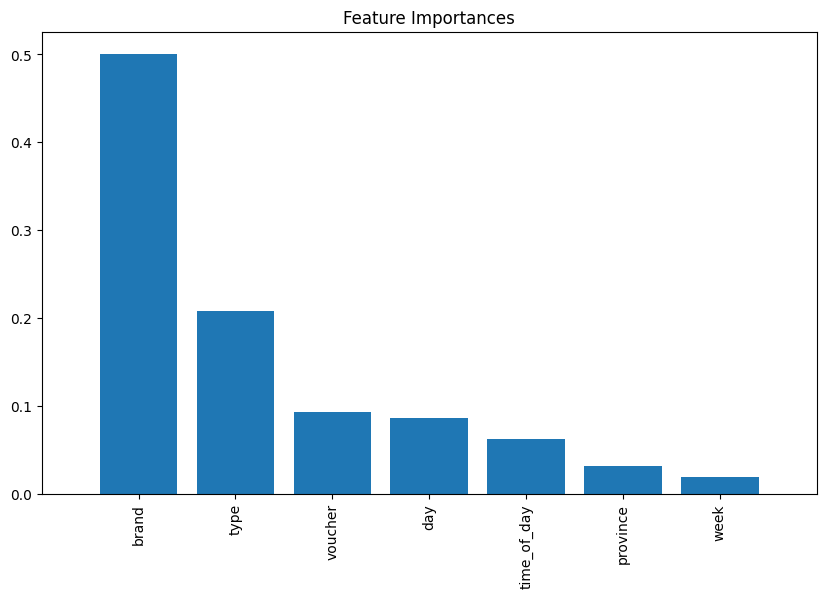

In [49]:
import matplotlib.pyplot as plt

# Get feature importances from the best model
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print("Top Feature Importances:")
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()


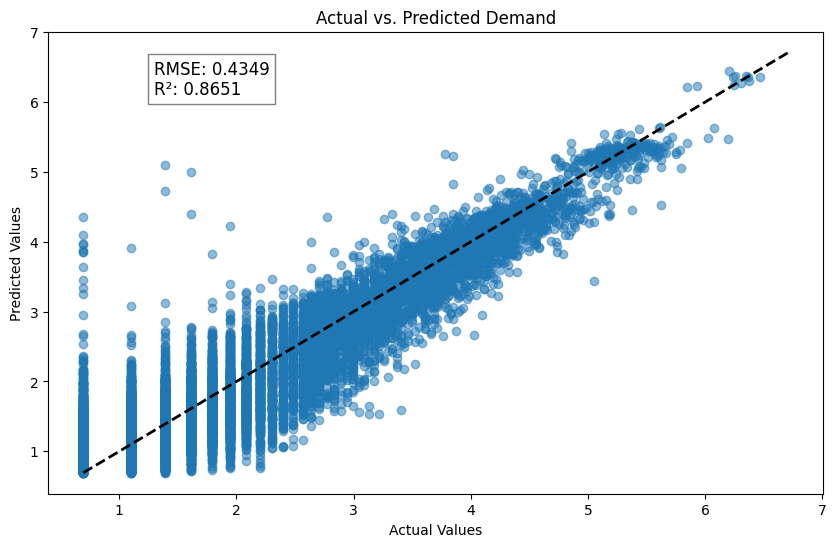

In [50]:
import matplotlib.pyplot as plt

# Predict and evaluate
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)  # Diagonal line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Demand')

# Add text annotations for RMSE and R² Score
plt.text(y.min() + 0.1 * (y.max() - y.min()), 
         y.max() - 0.1 * (y.max() - y.min()), 
         f'RMSE: {rmse:.4f}\nR²: {r2:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='black'))

plt.show()
